# 0.0

Descrição do problema de negócio

A InStyle é uma das maiores lojas de roupas dos Estados Unidos que passa por problemas de customer experience ou experiência do cliente.

O grande desafio de escalar o faturamento de uma loja é manter a qualidade do produto e a taxa de satisfação do cliente em alta.

À medida que a empresa alcance mais clientes, os processos internos de vendas que começa com a concepção do produto, passam pela divulgação do marketing e chegam até os sistemas de pagamento do financeiro começam a apresentar problemas.

O time de produtos tem dificuldade em determinar a necessidade da maioria dos clientes. O time de marketing enfrente desafios para determinar o cliente ideal e o time de desenvolvimento sofre com os grandes volumes de acessos no site e em seu aplicativo, causando quedas de sistema e tornando o site inoperante por algumas horas, impedindo as pessoas de comprar e assim, gerando muitas reclamações no atendimento, liderado pelo time de customer experience.

Portanto, a medição da satisfação dos clientes é extremamente importante para a empresa manter a boa reputação no mercado.

Um time interdisciplinar chamado de “War Room”, formado por profissionais de Produto, Marketing, Design, Dados e Desenvolvimento foi montado para garantir uma ótima experiência de compra ao cliente e uma alta taxa de satisfação, mesmo com o crescimento rápido do volume de vendas.

Uma das primeiras ações emergenciais do War Room foi fazer um atendimento pessoal aos clientes. Porém, a dificuldade inicial era identificar quais clientes teriam um nível de satisfação “Satisfeito” ou “Neutro/Insatisfeito”, para que o time conseguisse entrar em contato somente com os clientes “Neutro/Insatisfeito”.

Os Cientistas de Dados do War Room ficaram com a tarefa de treinar um algoritmo para classificar os clientes de uma planilha em “Satisfeito” ou “Neutro/Insatisfeito”, prevendo quais clientes ficarão Insatisfeitos e portanto agindo rápido para entender o motivo da insatisfação e reverter o cenário do cliente.

In [1]:
import os
import numpy                as np
import pandas               as pd
import pickle
import seaborn              as sns
import inflection
import matplotlib.pyplot    as plt 
import plotly.graph_objects as go

from sklearn.preprocessing import LabelEncoder

In [2]:
def desc_num(num_attributes):
    #Medidas de tendencia central - mmedia e mediana
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    #Medidas de dispersão - desvio padrão, min, max, range, skewness, kurtosis
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()

    m.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

    display(m)

In [3]:
BASE_DIR = os.path.abspath('')
DATA_DIR = os.path.join(BASE_DIR,'data')
#IMAG_DIR = os.path.join(BASE_DIR,'images')
#MODE_DIR = os.path.join(BASE_DIR,'models')

df_raw = pd.read_csv(os.path.join(DATA_DIR,'train.csv'))

# 1.0 Descrição dos dados

## 1.1 Renomeando Colunas

In [17]:
df1 = df_raw.copy()
#0 Neutro
#1 satisfeito

In [18]:
df1.columns = ['id','gender','customer_type','age','type_of_purchase','store_size','store_distance','in_store_wifi',
               'open_close_time_convenient','easy_of_online_shopping','store_location','toilet_cleaning','dressing_room','waiting_room',
               'kids_entertainment','seller_service','showroom','self_store','purchase_service','store_service','cleanliness','carrier_delay_in_minutes',
               'delivery_delay_in_minutes','satisfaction']

## 1.2 Descrição de features

In [19]:
num_attributes = df1.drop(['id'],axis=1).select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])


display(num_attributes.apply(lambda x: x.unique().shape[0]))
display(cat_attributes.apply(lambda x: x.unique()))

age                             75
store_distance                3802
in_store_wifi                    6
open_close_time_convenient       6
easy_of_online_shopping          6
store_location                   6
toilet_cleaning                  6
dressing_room                    6
waiting_room                     6
kids_entertainment               6
seller_service                   6
showroom                         6
self_store                       5
purchase_service                 6
store_service                    6
cleanliness                      6
carrier_delay_in_minutes       446
delivery_delay_in_minutes      456
dtype: int64

gender                                       [Male, Female]
customer_type           [Loyal Customer, disloyal Customer]
type_of_purchase                           [Personal, Gift]
store_size                           [Small, Large, Medium]
satisfaction        [Neutral or Dissatisfaction, Satisfied]
dtype: object

In [7]:
desc_num(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,7.0,85.0,78.0,39.379706,40.0,15.114891,-0.004516,-0.719568
1,store_distance,31.0,4983.0,4952.0,1189.448375,843.0,997.142482,1.109466,0.268535
2,in_store_wifi,0.0,5.0,5.0,2.729683,3.0,1.327823,0.040408,-0.846170
3,open_close_time_convenient,0.0,5.0,5.0,3.060296,3.0,1.525068,-0.334399,-1.037767
4,easy_of_online_shopping,0.0,5.0,5.0,2.756901,3.0,1.398923,-0.018294,-0.910346
5,store_location,0.0,5.0,5.0,2.976883,3.0,1.277615,-0.058889,-1.030283
6,toilet_cleaning,0.0,5.0,5.0,3.202129,3.0,1.329526,-0.151279,-1.145453
7,dressing_room,0.0,5.0,5.0,3.250375,3.0,1.349502,-0.453852,-0.702006
8,waiting_room,0.0,5.0,5.0,3.439396,4.0,1.319081,-0.482775,-0.925702
9,kids_entertainment,0.0,5.0,5.0,3.358158,4.0,1.332984,-0.365131,-1.060696


## 1.3 Tipos e dimensões dos dados

In [8]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))
display(df1.dtypes)
display(df1.describe())

Number of Rows: 103904
Number of Columns: 24


id                              int64
gender                         object
customer_type                  object
age                             int64
type_of_purchase               object
store_size                     object
store_distance                  int64
in_store_wifi                   int64
open_close_time_convenient      int64
easy_of_online_shopping         int64
store_location                  int64
toilet_cleaning                 int64
dressing_room                   int64
waiting_room                    int64
kids_entertainment              int64
seller_service                  int64
showroom                        int64
self_store                      int64
purchase_service                int64
store_service                   int64
cleanliness                     int64
carrier_delay_in_minutes        int64
delivery_delay_in_minutes     float64
satisfaction                   object
dtype: object

,id,age,store_distance,in_store_wifi,open_close_time_convenient,easy_of_online_shopping,store_location,toilet_cleaning,dressing_room,waiting_room,kids_entertainment,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103594.000000
mean,64924.210502,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178678
std,37463.812252,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.698682
min,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32533.750000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,64856.500000,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,97368.250000,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,129880.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


## 1.4 Valores Nulos

In [9]:
df1.isna().sum()

id                              0
gender                          0
customer_type                   0
age                             0
type_of_purchase                0
store_size                      0
store_distance                  0
in_store_wifi                   0
open_close_time_convenient      0
easy_of_online_shopping         0
store_location                  0
toilet_cleaning                 0
dressing_room                   0
waiting_room                    0
kids_entertainment              0
seller_service                  0
showroom                        0
self_store                      0
purchase_service                0
store_service                   0
cleanliness                     0
carrier_delay_in_minutes        0
delivery_delay_in_minutes     310
satisfaction                    0
dtype: int64

## 1.5 Preenchimento/Alteração dos valores

In [10]:
#age                             75
#store_distance                3802
#in_store_wifi                    6
#open_close_time_convenient       6
#easy_of_online_shopping          6
#store_location                   6
#toilet_cleaning                  6
#dressing_room                    6
#waiting_room                     6
#kids_entertainment               6
#seller_service                   6
#showroom                         6
#self_store                       5
#purchase_service                 6
#store_service                    6
#cleanliness                      6
#carrier_delay_in_minutes       446
#delivery_delay_in_minutes      456

#gender                                       [Male, Female] (0 = Male, 1 = Female)
#customer_type           [Loyal Customer, disloyal Customer] (0 = Leal, 1 = "desleal")
#type_of_purchase                           [Personal, Gift] (0 = pessoal, 1 = presente)
#store_size                           [Small, Large, Medium] (1 = pequeno, 2=médio, 3=grande)
#satisfaction        [Neutral or Dissatisfaction, Satisfied] (0 = não satisfeito, 1 = satisfeito)

In [20]:
df1['gender'] =             [0 if x == 'Male'                       else 1 for x in df1['gender']]
df1['customer_type'] =      [0 if x == 'Loyal Customer'             else 1 for x in df1['customer_type']]
df1['type_of_purchase'] =   [0 if x == 'Personal'                   else 1 for x in df1['type_of_purchase']]
df1['satisfaction'] =       [0 if x == 'Neutral or Dissatisfaction' else 1 for x in df1['satisfaction']]
df1['store_size'] =         [1 if x == 'Small'                      else 2 if x=='Medium' else 3 for x in df1['store_size']]

In [49]:
df2 = df1.copy()

df2 = df1[df1['delivery_delay_in_minutes']<600]
df2 = df2[df2['carrier_delay_in_minutes']<600]
df2 = df2[df2['delivery_delay_in_minutes'].notnull()]


In [ ]:
df1['gender'] =             [0 if x == 'Male'                       else 1 for x in df1['gender']]
df1['customer_type'] =      [0 if x == 'Loyal Customer'             else 1 for x in df1['customer_type']]
df1['type_of_purchase'] =   [0 if x == 'Personal'                   else 1 for x in df1['type_of_purchase']]
df1['satisfaction'] =       [0 if x == 'Neutral or Dissatisfaction' else 1 for x in df1['satisfaction']]
df1['store_size'] =         [1 if x == 'Small'                      else 2 if x=='Medium' else 3 for x in df1['store_size']]
df2 = df1.copy()

df2 = df2[df2['delivery_delay_in_minutes'].notnull()]

In [50]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103573 entries, 0 to 103903
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          103573 non-null  int64  
 1   gender                      103573 non-null  int64  
 2   customer_type               103573 non-null  int64  
 3   age                         103573 non-null  int64  
 4   type_of_purchase            103573 non-null  int64  
 5   store_size                  103573 non-null  int64  
 6   store_distance              103573 non-null  int64  
 7   in_store_wifi               103573 non-null  int64  
 8   open_close_time_convenient  103573 non-null  int64  
 9   easy_of_online_shopping     103573 non-null  int64  
 10  store_location              103573 non-null  int64  
 11  toilet_cleaning             103573 non-null  int64  
 12  dressing_room               103573 non-null  int64  
 13  waiting_room       

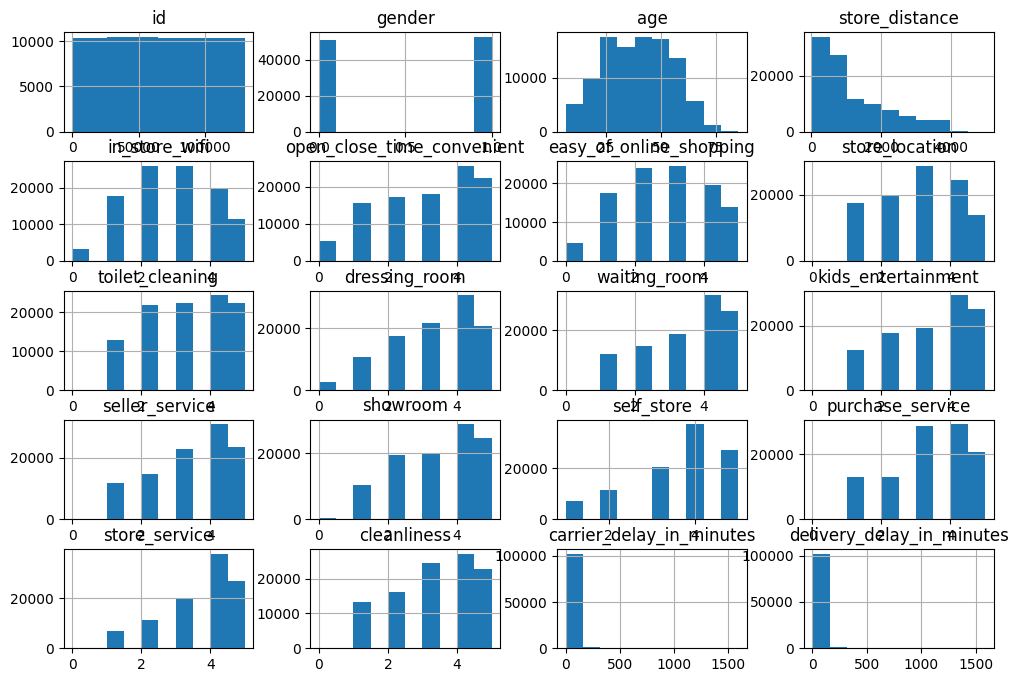

In [12]:
fig = df1.hist(grid=True, figsize=(12,8))

<Axes: >

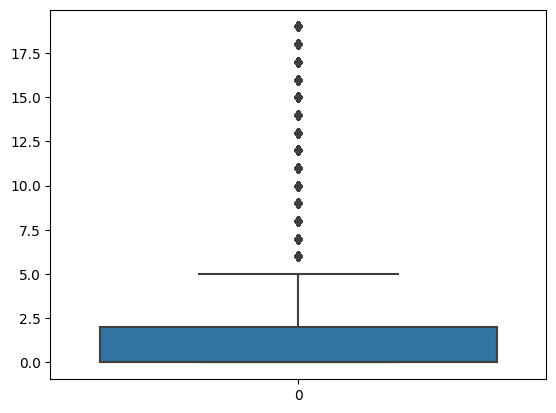

In [23]:
aux = df1[df1['delivery_delay_in_minutes']<20]['delivery_delay_in_minutes']
sns.boxplot(data = aux)

## Mapa Mental

In [133]:
<img src='images/Satisfao_do_Cliente.png' width='900'>

SyntaxError: invalid syntax (423578119.py, line 1)

### Criação de Hipóteses

#### Hipótese de Lojas

 - 1. Lojas mais próximas de centro deveriam satisfazer mais o cliente.

 - 2. Lojas pequenas tem maior numero de clientes insatisfeitos

#### Hipótese sobre os Clientes

In [ ]:
#Criacção de feature média das notas

- 1. Pessoas com mais que 45 anos tendem a  ficar insatisfeitas com a loja. (Lembrar de excluir a faixa etaria infantil)

- 2. Mulheres tendem a ficar mais insatisfeitas com a loja

- 3. Clientes fieis tendem a serem mais satisfeitos com a loja

In [ ]:
#age                             75
#store_distance                3802
#in_store_wifi                    6
#open_close_time_convenient       6
#easy_of_online_shopping          6
#store_location                   6
#toilet_cleaning                  6
#dressing_room                    6
#waiting_room                     6
#kids_entertainment               6
#seller_service                   6
#showroom                         6
#self_store                       5
#purchase_service                 6
#store_service                    6
#cleanliness                      6
#carrier_delay_in_minutes       446
#delivery_delay_in_minutes      456

#gender                                       [Male, Female] (0 = Male, 1 = Female)
#customer_type           [Loyal Customer, disloyal Customer] (0 = Leal, 1 = "desleal")
#type_of_purchase                           [Personal, Gift] (0 = pessoal, 1 = presente)
#store_size                           [Small, Large, Medium] (1 = pequeno, 2=médio, 3=grande)
#satisfaction        [Neutral or Dissatisfaction, Satisfied] (0 = não satisfeito, 1 = satisfeito)

In [141]:
df1['type_of_purchase'].value_counts()

type_of_purchase
1    71655
0    32249
Name: count, dtype: int64

## ?.? Analise univariada

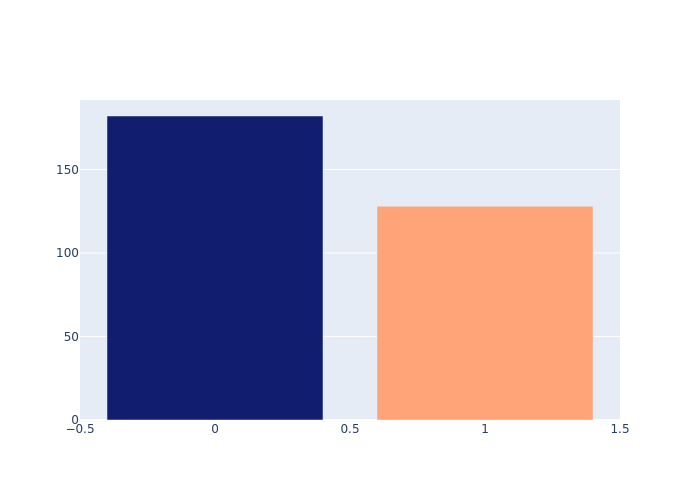

In [134]:
aux = df1[df1['delivery_delay_in_minutes'].isnull()][['satisfaction']]
aux = aux.loc[:,['satisfaction']].groupby('satisfaction').size().reset_index(name='qnt')
fig = go.Figure(go.Bar(x=aux['satisfaction'], y=aux['qnt'], marker_color=['#111D6F', '#FFA378']))
fig.show('png')

In [ ]:
aux = df1.loc[:,['satisfaction']].groupby('satisfaction').size().reset_index(name='qnt')

In [ ]:
display(df1[df1['delivery_delay_in_minutes']>0].shape)

display(df1[df1['delivery_delay_in_minutes']==0].shape)


# ?.? ML

In [75]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, confusion_matrix
from  xgboost import XGBClassifier

In [55]:
X = df2.drop('satisfaction', axis = 1)
y = df2['satisfaction'].copy() 

In [57]:
x_train, x_validation, y_train, y_validation = train_test_split(X, y, test_size=0.25)

In [65]:
xgb = XGBClassifier()

xgb_cv=cross_val_score(xgb,x_train,y_train,cv=5,scoring='precision')


In [67]:
xgb_f = XGBClassifier().fit(x_train, y_train)

In [73]:
yhat_xgb = xgb_f.predict( x_validation )

In [74]:
precision_score(y_validation,yhat_xgb)

0.9696225557071396

In [76]:
confusion_matrix(y_validation, yhat_xgb)

array([[14317,   334],
       [  582, 10661]])

# Submissão

In [110]:
df_test = pd.read_csv(os.path.join(DATA_DIR,'test.csv'))
df_test.columns = ['id','gender','customer_type','age','type_of_purchase','store_size','store_distance','in_store_wifi',
               'open_close_time_convenient','easy_of_online_shopping','store_location','toilet_cleaning','dressing_room','waiting_room',
               'kids_entertainment','seller_service','showroom','self_store','purchase_service','store_service','cleanliness','carrier_delay_in_minutes',
               'delivery_delay_in_minutes']

In [111]:
df_test['gender'] =             [0 if x == 'Male'                       else 1 for x in df_test['gender']]
df_test['customer_type'] =      [0 if x == 'Loyal Customer'             else 1 for x in df_test['customer_type']]
df_test['type_of_purchase'] =   [0 if x == 'Personal'                   else 1 for x in df_test['type_of_purchase']]
df_test['store_size'] =         [1 if x == 'Small'                      else 2 if x=='Medium' else 3 for x in df_test['store_size']]
df2 = df_test.copy()

#df2 = df2[df2['delivery_delay_in_minutes'].notnull()]

In [112]:
df2.isnull()

,id,gender,customer_type,age,type_of_purchase,store_size,store_distance,in_store_wifi,open_close_time_convenient,easy_of_online_shopping,...,waiting_room,kids_entertainment,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25971,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
25972,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
25973,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
25974,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [113]:
yhat_test = xgb_f.predict( df2 )

In [126]:
sub = pd.concat((df_test['id'], (pd.Series(yhat_test))), axis=1)

sub = sub.rename(columns={0:'Satisfaction'})

sub = sub.set_index('id')
sub
sub.to_csv('sub_xgb_model_1.csv')

In [122]:
sub

,id,Satisfaction
0,19556,1
1,90035,1
2,12360,0
3,77959,1
4,36875,0
...,...,...
25971,78463,0
25972,71167,1
25973,37675,0
25974,90086,1


In [115]:
sub.isnull()

,satisfaction
id,
19556,False
90035,False
12360,False
77959,False
36875,False
...,...
78463,False
71167,False
37675,False
